#### Hand Sign Recognition -> It is a MultiClass Classification hence we will be using the MLP as our model architecture

# Imports

In [1]:
from numpy.random import seed
seed(888)
from tensorflow.random import set_seed
set_seed(404)

In [2]:
import os
import numpy as np
import cv2

import tensorflow as tf

from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Lambda, Input, Reshape
from tensorflow.keras.callbacks import TensorBoard

from time import strftime

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

# Constants

In [4]:
train_dir_alphabets = './Sign-Language-Alphabets-Dataset/asl_alphabet_train/asl_alphabet_train/'
test_dir_alphabets = './Sign-Language-Alphabets-Dataset/asl_alphabet_test/asl_alphabet_test/'
train_dir_digits = './Sign-Language-Digits-Dataset/Dataset/'
test_dir_digits = './Sign-Language-Digits-Dataset/Examples/'

map_idx_to_char = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F',
                  6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L',
                  12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
                  18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
                  24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space',
                  29: 'other'}

map_char_to_idx = {v: k for k, v in map_idx_to_char.items()}

classes_alphabet = list(map_idx_to_char.values())

classes_digits = ['0','1','2','3','4','5','6','7','8','9']

IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_PIXELS = IMAGE_HEIGHT * IMAGE_WIDTH
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
VALIDATION_SIZE=1000
VALIDATION_RATIO = 0.1
NR_CLASSES = len(classes_alphabet) - 1
LOGGING_PATH = 'tensorboard_hand-sign_alphabets_logs/'

# A Look At The Data

## The Alphabets

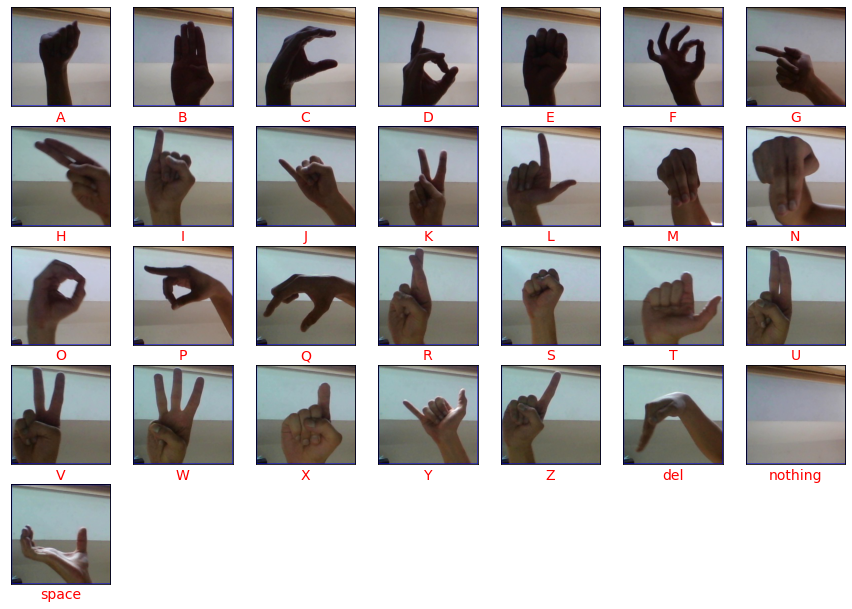

In [5]:
plt.figure(figsize=(15, 15))
for i in range (0,29):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path = train_dir_alphabets + "/{0}/{0}1.jpg".format(classes_alphabet[i])
    img = plt.imread(path)
    plt.imshow(img)
    label = plt.xlabel(classes_alphabet[i], fontsize=14)
    label.set_color("red")


In [6]:
path = train_dir_alphabets + "/{0}/{0}1.jpg".format(classes_alphabet[0])
img = plt.imread(path)
x, y, c = img.shape
print(f'width = {x} \t| height = {y} \t| channels = {c}')

width = 200 	| height = 200 	| channels = 3


## The Digits

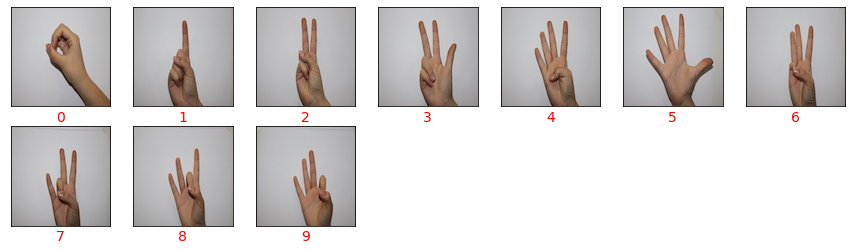

In [7]:
plt.figure(figsize=(15, 15))
for i in range (0,10):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path = train_dir_digits + "{0}/".format(classes_digits[i])
    data = os.listdir(path)
    path = path + data[0]
    img = plt.imread(path)
    plt.imshow(img)
    label = plt.xlabel(classes_digits[i], fontsize=14)
    label.set_color("red")


#### From the above data it is clear that we cannot have a single model for digits and alphabets as it will create bias due to different number of data points and some alphabets are too similar to some digits

# Continuing For Alphabets

# Get The Data

In [7]:
def load_data(train_dir_alphabets):
    images = []
    labels = []
    size = IMAGE_HEIGHT,IMAGE_WIDTH
    for directory in os.listdir(train_dir_alphabets):
        for image in os.listdir(train_dir_alphabets + "/" + directory):
            img = cv2.imread(train_dir_alphabets + '/' + directory + '/' + image)
            final_img = cv2.resize(img, size)
            images.append(final_img)
            idx = map_char_to_idx.get(directory)
            labels.append(idx)
        print('loaded:', directory, 'label:', idx)
    images = np.array(images)
    labels = utils.to_categorical(labels)
    
    return images,labels

In [8]:
%%time

images,labels = load_data(train_dir_alphabets)
nr_images, x, y, c = images.shape
print(f'images = {nr_images} \t| width = {x} \t| height = {y} \t| channels = {c}')

loaded: A label: 0
loaded: B label: 1
loaded: C label: 2
loaded: D label: 3
loaded: del label: 26
loaded: E label: 4
loaded: F label: 5
loaded: G label: 6
loaded: H label: 7
loaded: I label: 8
loaded: J label: 9
loaded: K label: 10
loaded: L label: 11
loaded: M label: 12
loaded: N label: 13
loaded: nothing label: 27
loaded: O label: 14
loaded: P label: 15
loaded: Q label: 16
loaded: R label: 17
loaded: S label: 18
loaded: space label: 28
loaded: T label: 19
loaded: U label: 20
loaded: V label: 21
loaded: W label: 22
loaded: X label: 23
loaded: Y label: 24
loaded: Z label: 25
images = 87000 	| width = 64 	| height = 64 	| channels = 3
Wall time: 1min 50s


# Exlpore The Data

In [9]:
nr_images, x, y, c = images.shape
print(f'images = {nr_images} \t| width = {x} \t| height = {y} \t| channels = {c}')

images = 87000 	| width = 64 	| height = 64 	| channels = 3


# Data Preprocessing 

#### Now to be done inside the model

# Train Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1)

In [11]:
X_train.shape

(78300, 64, 64, 3)

In [12]:
X_test.shape

(8700, 64, 64, 3)

In [13]:
y_test.shape

(8700, 29)

# Tensorflow Architecture Setup

#### Hyperparameters

In [14]:
nr_epochs = 50
learning_rate = 1e-3

#### Defining the model

### Model 2

In [49]:
mlp2 = Sequential()

mlp2.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))

mlp2.add(Conv2D(128 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))

mlp2.add(Conv2D(128 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))

mlp2.add(Conv2D(128 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))


mlp2.add(Conv2D(256 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))

mlp2.add(Flatten())

mlp2.add(Dropout(0.5))
mlp2.add(Dense(1024, activation='sigmoid'))
mlp2.add(Dense(NR_CLASSES, activation='softmax'))

In [50]:
mlp2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 128)        

### Model 2 with preprocessing

In [148]:
def preprocess_image(pixels):
    images = tf.cast(pixels,'float32') /255.0
    return images

In [15]:
mlp2_preprocess = Sequential()

mlp2_preprocess.add(Rescaling(1.0 / 255))

mlp2_preprocess.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2_preprocess.add(MaxPooling2D(pool_size = (2, 2)))

mlp2_preprocess.add(Conv2D(128 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2_preprocess.add(MaxPooling2D(pool_size = (2, 2)))

mlp2_preprocess.add(Conv2D(128 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2_preprocess.add(MaxPooling2D(pool_size = (2, 2)))

mlp2_preprocess.add(Conv2D(128 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2_preprocess.add(MaxPooling2D(pool_size = (2, 2)))


mlp2_preprocess.add(Conv2D(256 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2_preprocess.add(MaxPooling2D(pool_size = (2, 2)))

mlp2_preprocess.add(Flatten())

mlp2_preprocess.add(Dropout(0.5))
mlp2_preprocess.add(Dense(1024, activation='sigmoid'))
mlp2_preprocess.add(Dense(NR_CLASSES, activation='softmax'))

In [17]:
mlp2_preprocess.build(X_train.shape)

In [18]:
mlp2_preprocess.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (78300, 64, 64, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (78300, 64, 64, 64)       1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (78300, 32, 32, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (78300, 32, 32, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (78300, 16, 16, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (78300, 16, 16, 128)      147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (78300, 8, 8, 128)        0

# Tensorboard Setup

In [19]:
def get_tensorboard(model_name):
    folder_name = f'{model_name} at {strftime("%H %M")}'
    dir_paths = os.path.join(LOGGING_PATH, folder_name)
    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully created directory')
    return TensorBoard(log_dir=dir_paths, histogram_freq=1)

# Train the models

In [20]:
adam = Adam(lr=learning_rate)

In [21]:
mlp2_preprocess.compile(loss ='categorical_crossentropy', optimizer=adam ,metrics =['accuracy'])

### Train

In [22]:
history2_preprocess = mlp2_preprocess.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=VALIDATION_RATIO, shuffle = True, verbose=1,
                  callbacks=[get_tensorboard('Model 2 MLP-PRE-VAL')])

Successfully created directory
Epoch 1/5
1102/1102 [==============================] - 28s 21ms/step - loss: 2.9239 - accuracy: 0.1716 - val_loss: 0.1230 - val_accuracy: 0.9660
Epoch 2/5
1102/1102 [==============================] - 22s 20ms/step - loss: 0.1506 - accuracy: 0.9504 - val_loss: 0.0414 - val_accuracy: 0.9860
Epoch 3/5
1102/1102 [==============================] - 22s 20ms/step - loss: 0.0501 - accuracy: 0.9842 - val_loss: 0.0148 - val_accuracy: 0.9949
Epoch 4/5
1102/1102 [==============================] - 22s 20ms/step - loss: 0.0412 - accuracy: 0.9861 - val_loss: 0.0085 - val_accuracy: 0.9973
Epoch 5/5
1102/1102 [==============================] - 22s 20ms/step - loss: 0.0345 - accuracy: 0.9887 - val_loss: 0.0091 - val_accuracy: 0.9967


# Visualizing Accuracy

# Model 2

Text(0.5, 1.0, 'Accuracy evolution')

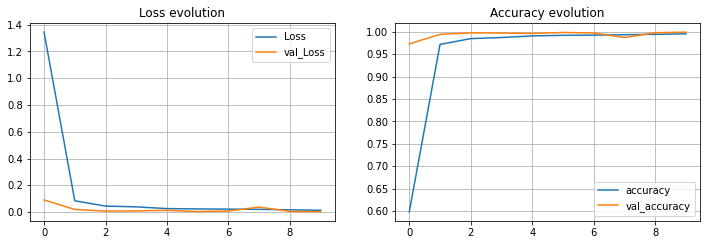

In [49]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history2.history['loss'], label='Loss')
plt.plot(history2.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

# Model 2 Pre process

Text(0.5, 1.0, 'Accuracy evolution')

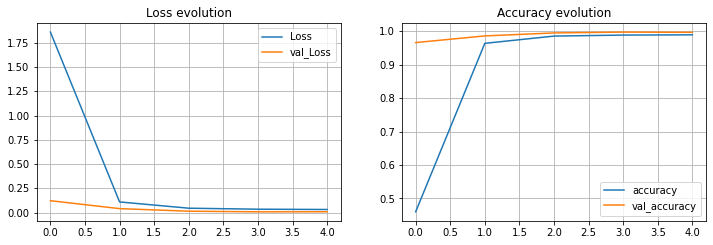

In [23]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history2_preprocess.history['loss'], label='Loss')
plt.plot(history2_preprocess.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history2_preprocess.history['accuracy'], label='accuracy')
plt.plot(history2_preprocess.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

### Model 2 is the superior one hence model 2 will be selected

In [25]:
mlp2_preprocess.save('Alphabet Classifier With Preprocessing')

INFO:tensorflow:Assets written to: Alphabet Classifier With Preprocessing\assets


# Testing And Evaluation

In [26]:
test_loss, test_acc = mlp2_preprocess.evaluate(X_test, y_test)

272/272 [==============================] - 2s 6ms/step - loss: 0.0093 - accuracy: 0.9967


In [28]:
pred = mlp2_preprocess.predict(X_test)

In [31]:
import itertools

In [32]:
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(classes_alphabet))
    plt.xticks(tick_marks, classes_alphabet, rotation=45)
    plt.yticks(tick_marks, classes_alphabet)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()


<Figure size 1440x1440 with 0 Axes>

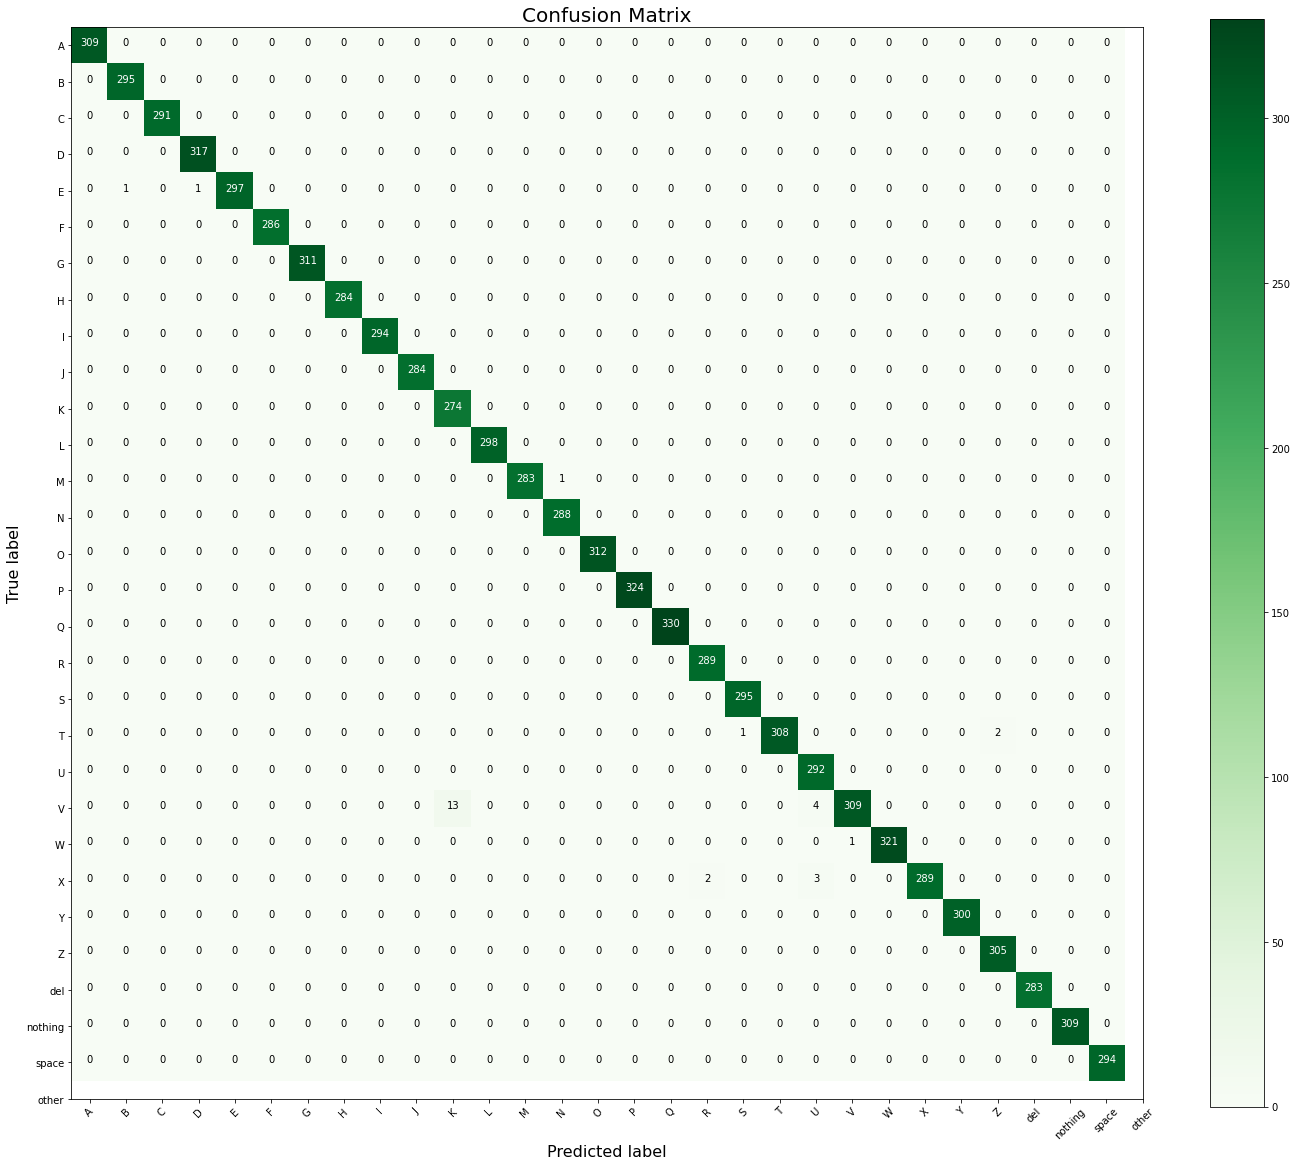

In [33]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(y_test, pred)
plt.show()

# Convert Model into TFLite

In [34]:
converter = tf.lite.TFLiteConverter.from_saved_model('Alphabet Classifier With Preprocessing')
tflite_model = converter.convert()

with open('Alphabet_Classifier__Preprocess_Lite.tflite', 'wb') as f:
  f.write(tflite_model)


# Testing the saved model

In [45]:
saved_model = tf.keras.models.load_model('Alphabet Classifier With Preprocessing')

In [54]:
# for i in range(0,29):
#     if i == 26:
#         continue
images = []
labels = []
size = IMAGE_HEIGHT,IMAGE_WIDTH
for image in os.listdir(test_dir_alphabets):
    img = cv2.imread(test_dir_alphabets+ '/' + image)
    final_img = cv2.resize(img, size)
    images.append(final_img)
    idx = map_char_to_idx.get(image.split('_')[0])
    labels.append(idx)
    print('loaded:', image, 'label:', idx)
images = np.array(images)
labels_categorical = utils.to_categorical(labels)

loaded: A_test.jpg label: 0
loaded: B_test.jpg label: 1
loaded: C_test.jpg label: 2
loaded: D_test.jpg label: 3
loaded: E_test.jpg label: 4
loaded: F_test.jpg label: 5
loaded: G_test.jpg label: 6
loaded: H_test.jpg label: 7
loaded: I_test.jpg label: 8
loaded: J_test.jpg label: 9
loaded: K_test.jpg label: 10
loaded: L_test.jpg label: 11
loaded: M_test.jpg label: 12
loaded: nothing_test.jpg label: 27
loaded: N_test.jpg label: 13
loaded: O_test.jpg label: 14
loaded: P_test.jpg label: 15
loaded: Q_test.jpg label: 16
loaded: R_test.jpg label: 17
loaded: space_test.jpg label: 28
loaded: S_test.jpg label: 18
loaded: T_test.jpg label: 19
loaded: U_test.jpg label: 20
loaded: V_test.jpg label: 21
loaded: W_test.jpg label: 22
loaded: X_test.jpg label: 23
loaded: Y_test.jpg label: 24
loaded: Z_test.jpg label: 25


In [55]:
predicted_classes = np.argmax(saved_model.predict(images), axis=-1)

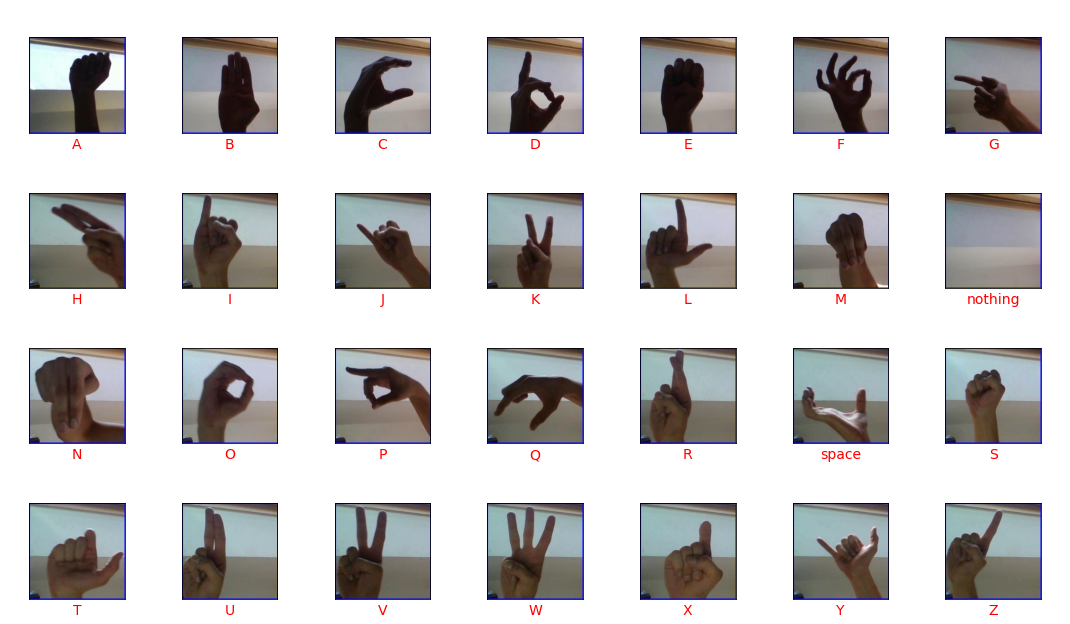

In [56]:
plt.figure(figsize=(15, 15))
for i in range (0,28):
    plt.subplot(7,7,i+1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    path = test_dir_alphabets + "{0}_test.jpg".format(map_idx_to_char.get(int(labels[i])))
    img = plt.imread(path)
    plt.imshow(img)
    label = plt.xlabel(map_idx_to_char.get(int(labels[i])), fontsize=14)
    title = plt.title(f"Prediction Class = {predicted_classes[i]:0.1f}\n True Class = {labels[i]:0.1f}")
    title.set_color("white")
    label.set_color("red")